In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pymoo.algorithms.moo.unsga3 import UNSGA3
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.core.problem import ElementwiseProblem
from pymoo.optimize import minimize

In [2]:
N = 5  # Number of PEVGs
C = 99  # Grid capacity (MWh)

b_n = np.random.randint(35, 65, N)  # Battery capacities (MWh)
s_n = np.random.uniform(1, 2, N)    # Satisfaction parameters

In [3]:
# --- Define the U-NSGA-III Problem for 2 Objectives ---
class EVChargingProblemUNSGA3(ElementwiseProblem):
    def __init__(self):
        super().__init__(n_var=N + 1,  
                         n_obj=2, 
                         n_constr=1, 
                         xl=np.array([20] + [0] * N), 
                         xu=np.array([50] + [min(b_n[i], C) for i in range(N)]))  

    def _evaluate(self, X, out, *args, **kwargs):
        p = X[0]   
        x_n = X[1:]  

        revenue = p * np.sum(x_n)  
        utility = np.sum(b_n * x_n - 0.5 * s_n * x_n**2 - p * x_n)

        wastage = C - np.sum(x_n)  

        out["F"] = [-revenue, -utility]  
        out["G"] = [-wastage] 

ref_dirs = get_reference_directions("das-dennis", 2, n_partitions=80) 

algorithm = UNSGA3(
    pop_size=100,
    ref_dirs=ref_dirs  
)



In [4]:
res = minimize(EVChargingProblemUNSGA3(),
               algorithm,
               ("n_gen", 150),  
               seed=42,
               verbose=False,
               save_history=True)  

F = res.F
revenue, utility = -F[:, 0], -F[:, 1]


C:\Users\hp\anaconda3\Lib\site-packages\numpy\core\numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


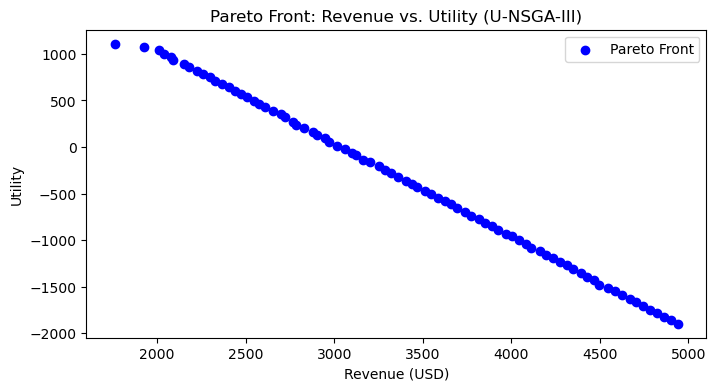

In [5]:
# --- 2D Pareto Front ---
plt.figure(figsize=(8, 4))
plt.scatter(revenue, utility, c='blue', label='Pareto Front')
plt.xlabel('Revenue (USD)')
plt.ylabel('Utility')
plt.title('Pareto Front: Revenue vs. Utility (U-NSGA-III)')
plt.legend()
# plt.savefig('pareto_front_unsga3_2obj.jpg')
plt.show()

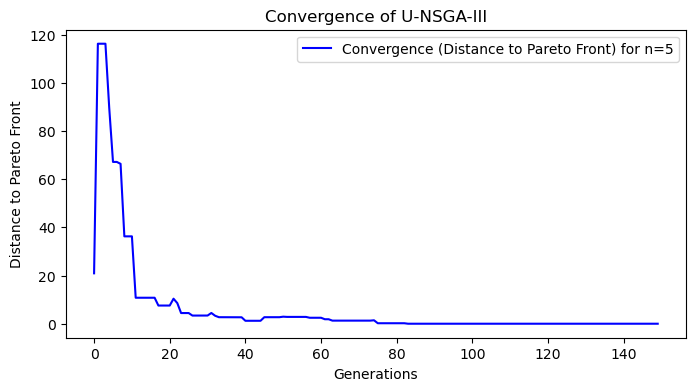

In [6]:
# --- Convergence Plot: Distance to Pareto Front ---
pareto_front = np.column_stack((revenue, utility))
best_distances = []

for gen in res.history:
    gen_F = -gen.pop.get("F")  # Get objective values in this generation

    distances = [np.min(np.linalg.norm(pf - gen_F, axis=1)) for pf in pareto_front]
    
    best_distances.append(np.min(distances))

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(best_distances, label="Convergence (Distance to Pareto Front) for n=5", color='b')
ax.set_xlabel('Generations')
ax.set_ylabel('Distance to Pareto Front')
ax.set_title('Convergence of U-NSGA-III')
plt.legend()
# plt.savefig('convergence_unsga3_2obj.jpg')
plt.show()


In [7]:
N = 10 
C = 99 

b_n = np.random.randint(35, 65, N) 
s_n = np.random.uniform(1, 2, N)    

In [8]:
res = minimize(EVChargingProblemUNSGA3(),
               algorithm,
               ("n_gen", 150),  
               seed=42,
               verbose=False,
               save_history=True)  

F = res.F
revenue, utility = -F[:, 0], -F[:, 1]

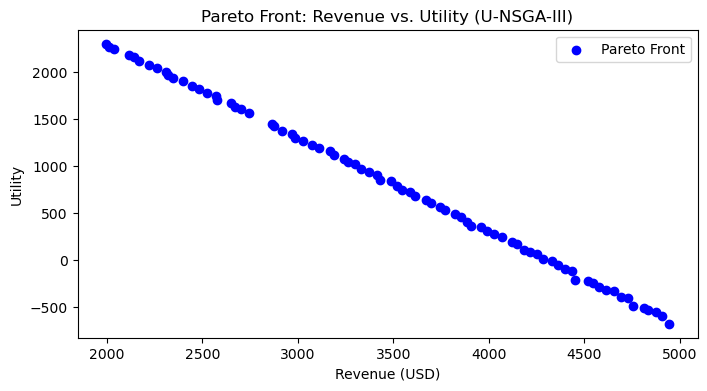

In [9]:

plt.figure(figsize=(8, 4))
plt.scatter(revenue, utility, c='blue', label='Pareto Front')
plt.xlabel('Revenue (USD)')
plt.ylabel('Utility')
plt.title('Pareto Front: Revenue vs. Utility (U-NSGA-III)')
plt.legend()
# plt.savefig('pareto_front_unsga3_2obj.jpg')
plt.show()

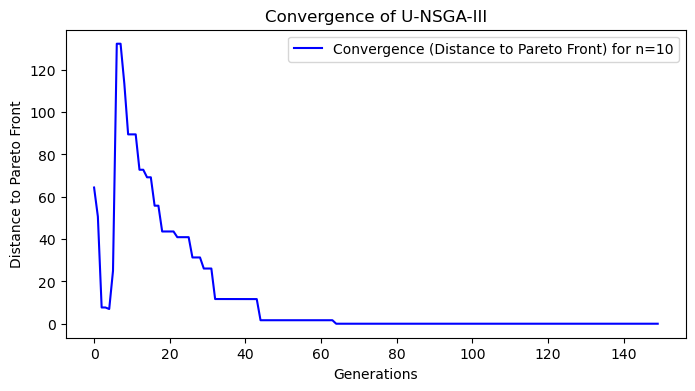

In [10]:

pareto_front = np.column_stack((revenue, utility))
best_distances = []

for gen in res.history:
    gen_F = -gen.pop.get("F")  

    distances = [np.min(np.linalg.norm(pf - gen_F, axis=1)) for pf in pareto_front]
    
    best_distances.append(np.min(distances))

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(best_distances, label="Convergence (Distance to Pareto Front) for n=10", color='b')
ax.set_xlabel('Generations')
ax.set_ylabel('Distance to Pareto Front')
ax.set_title('Convergence of U-NSGA-III')
plt.legend()
# plt.savefig('convergence_unsga3_2obj.jpg')
plt.show()


In [11]:
N = 10 
C = 99 

b_n = np.random.randint(35, 65, N) 
s_n = np.random.uniform(1, 2, N)    

In [12]:
res = minimize(EVChargingProblemUNSGA3(),
               algorithm,
               ("n_gen", 150),  
               seed=42,
               verbose=False,
               save_history=True)  

F = res.F
revenue, utility = -F[:, 0], -F[:, 1]

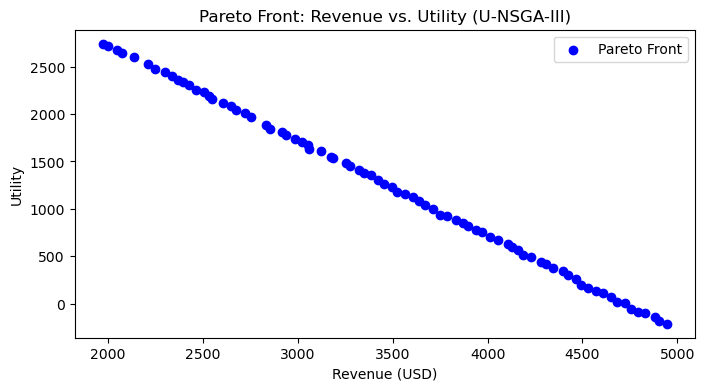

In [13]:

plt.figure(figsize=(8, 4))
plt.scatter(revenue, utility, c='blue', label='Pareto Front')
plt.xlabel('Revenue (USD)')
plt.ylabel('Utility')
plt.title('Pareto Front: Revenue vs. Utility (U-NSGA-III)')
plt.legend()
# plt.savefig('pareto_front_unsga3_2obj.jpg')
plt.show()

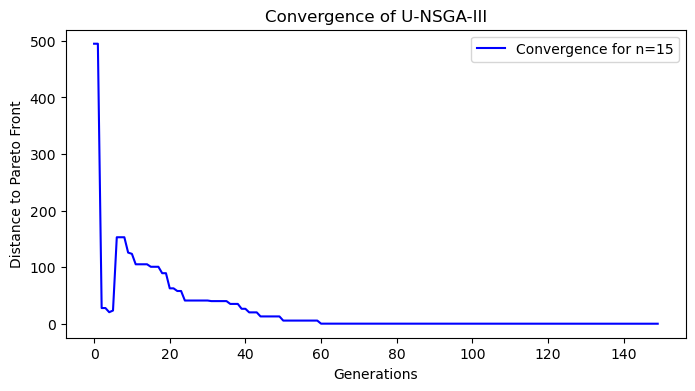

In [14]:

pareto_front = np.column_stack((revenue, utility))
best_distances = []

for gen in res.history:
    gen_F = -gen.pop.get("F")  

    distances = [np.min(np.linalg.norm(pf - gen_F, axis=1)) for pf in pareto_front]
    
    best_distances.append(np.min(distances))

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(best_distances, label="Convergence for n=15", color='b')
ax.set_xlabel('Generations')
ax.set_ylabel('Distance to Pareto Front')
ax.set_title('Convergence of U-NSGA-III')
plt.legend()
# plt.savefig('convergence_unsga3_2obj.jpg')
plt.show()
